# Task 1 - Exploring Hyperparameters

## Batch Size

### Approach

Firstly I checked again what the batch size of a CNN is. It is the number of data-samples that will be put through together in one interation (not epoch) of the network."After each iteration the weights in CNN will be updated. If every data-sample was put through the network, a epoch is finished. So the batch-size on one way determines how 'long' a epoch will be. 

The minimum batch-size for every CNN would be 1 and the maximum batch size the number of data-samples available.Minimum and maximum values should be definitly tested.

I selected this six values to represent a good range of results:
- 1
- 8
- 32
- 128
- 256
- 512 (=max of the samples)

### Assumptions
I think the higher the batch size, the longer it will take to train the model for each iteration and also the lower the prediction accuracy will be. This could be because if you put all the data-samples in one go through the CNN, the weights will only update once (because there is only one iteration per epoch).

In [7]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [8]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [9]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [10]:
# load images and annotations

In [11]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

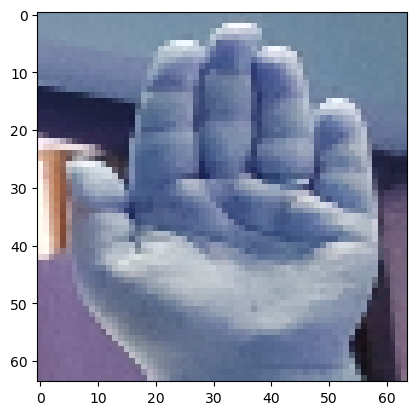

In [12]:
plt.imshow(random.sample(images, 1)[0])

In [13]:
# split data set into train and test


In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


In [15]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [56]:
# variables for hyperparameters
batch_size = 1
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [57]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
512/512 [==============================] - 4s 7ms/step - loss: 1.1177 - accuracy: 0.4180 - val_loss: 1.1733 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
512/512 [==============================] - 4s 7ms/step - loss: 1.1199 - accuracy: 0.4062 - val_loss: 1.0001 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 3/50
512/512 [==============================] - 4s 7ms/step - loss: 1.0224 - accuracy: 0.4395 - val_loss: 0.9439 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 4/50
512/512 [==============================] - 4s 7ms/step - loss: 0.9143 - accuracy: 0.5371 - val_loss: 0.7684 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 5/50
512/512 [==============================] - 4s 7ms/step - loss: 0.7321 - accuracy: 0.6797 - val_loss: 0.5233 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 6/50
512/512 [==============================] - 4s 7ms/step - loss: 0.6254 - accuracy: 0.7480 - val_loss: 0.3798 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 7/50
512/512 [==============================] - 4s 7ms/step - lo

In [58]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip)  (1, 64, 64, 3)           0         
                                                                 
 random_contrast_11 (RandomC  (1, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_33 (Conv2D)          (1, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_33 (MaxPoolin  (1, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (1, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_34 (MaxPoolin  (1, 6, 6, 32)          

In [59]:
# plot accuracy and loss of the training process

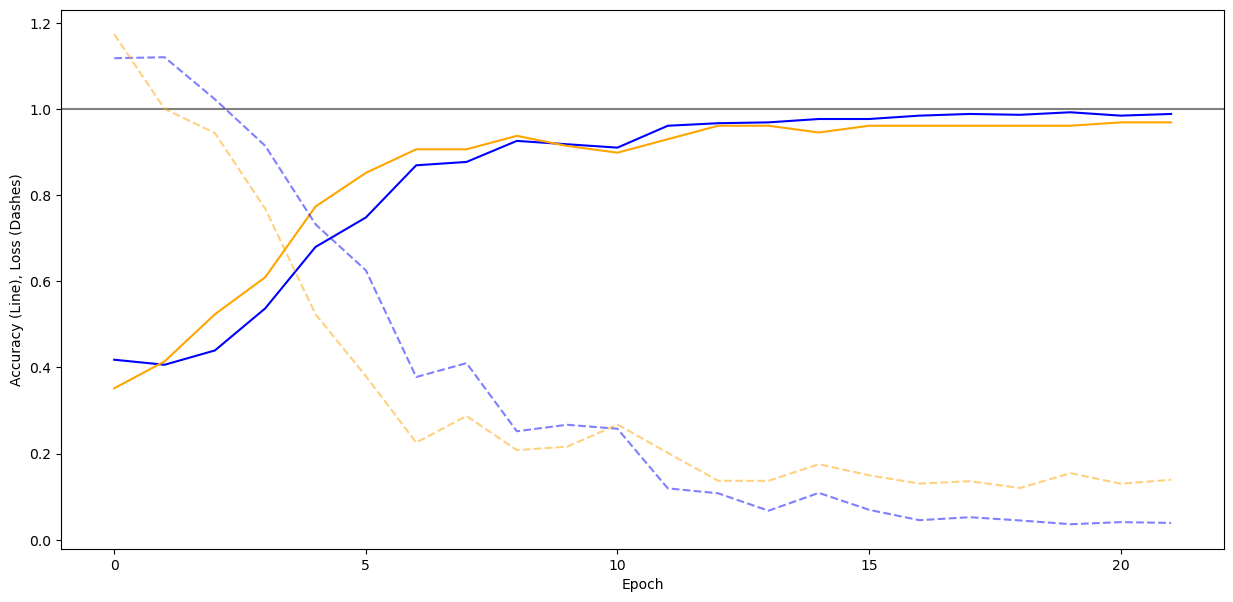

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [61]:
# visualize classification results with a confusion matrix

4/4 [==============================] - 0s 14ms/step
before [[5.65678835e-01 5.51484292e-04 4.33769614e-01]
 [9.99015093e-01 9.79915145e-04 5.04061200e-06]
 [9.99976754e-01 2.00505419e-05 3.19819219e-06]
 [1.12077268e-03 4.81399547e-06 9.98874366e-01]
 [9.99955058e-01 3.68973124e-05 7.95465166e-06]
 [9.99995708e-01 4.25973803e-06 1.27841904e-11]
 [1.00000000e+00 1.21464057e-08 5.06015282e-12]
 [1.10744655e-01 8.88706207e-01 5.49252785e-04]
 [9.99996185e-01 3.77239803e-06 2.48463898e-08]
 [9.99918938e-01 4.83217991e-05 3.27282069e-05]
 [5.66765480e-03 3.48536596e-05 9.94297564e-01]
 [4.30228422e-12 1.00000000e+00 1.49614119e-15]
 [9.21872854e-01 7.25741610e-02 5.55287767e-03]
 [9.14536696e-03 2.73562706e-04 9.90581095e-01]
 [1.00000000e+00 5.17992405e-08 3.12490946e-13]
 [3.34927929e-04 2.03706750e-05 9.99644637e-01]
 [6.87126732e-16 1.00000000e+00 4.66168095e-21]
 [3.79183824e-04 2.55308532e-05 9.99595344e-01]
 [1.75078982e-04 9.99816835e-01 8.05556010e-06]
 [2.55267906e-07 4.89975194e-

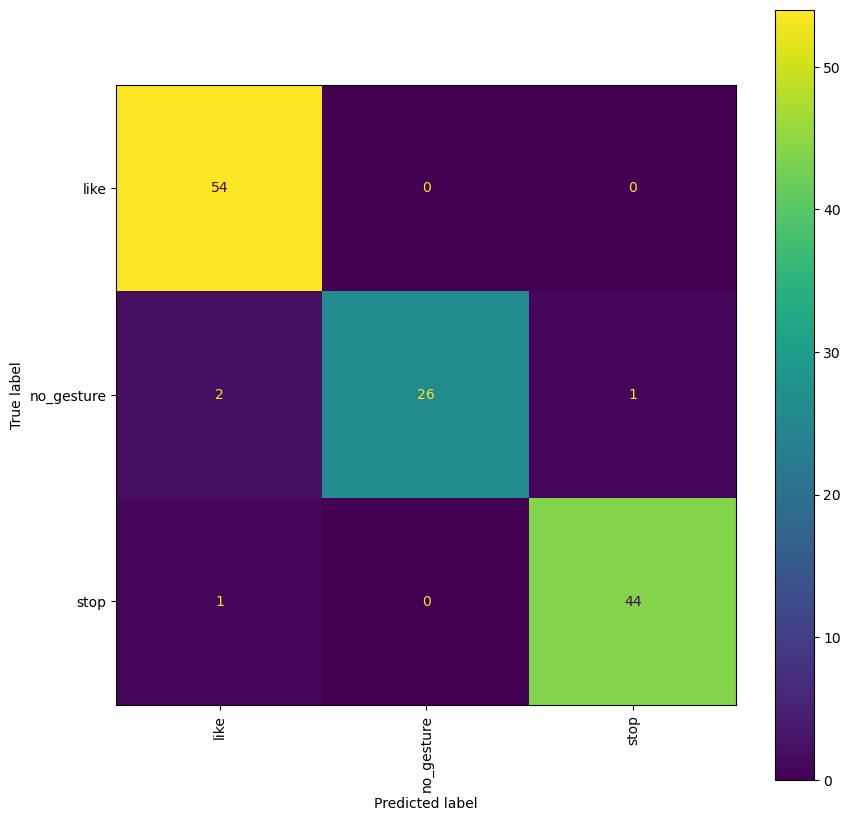

In [63]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [64]:
# next model

In [65]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [66]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 2s 26ms/step - loss: 1.0727 - accuracy: 0.4082 - val_loss: 1.1138 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2s 25ms/step - loss: 1.0564 - accuracy: 0.4336 - val_loss: 1.0729 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 2s 26ms/step - loss: 1.0829 - accuracy: 0.4199 - val_loss: 1.0369 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2s 25ms/step - loss: 0.9679 - accuracy: 0.4785 - val_loss: 0.9212 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 2s 25ms/step - loss: 0.7858 - accuracy: 0.6621 - val_loss: 0.5848 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2s 26ms/step - loss: 0.5212 - accuracy: 0.8027 - val_loss: 0.2236 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 2s 25ms/step - loss: 0.3

In [67]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_12 (RandomC  (8, 64, 64, 3)           0         
 ontrast)                                                        
                                                                 
 conv2d_36 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_36 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_37 (MaxPoolin  (8, 6, 6, 32)          

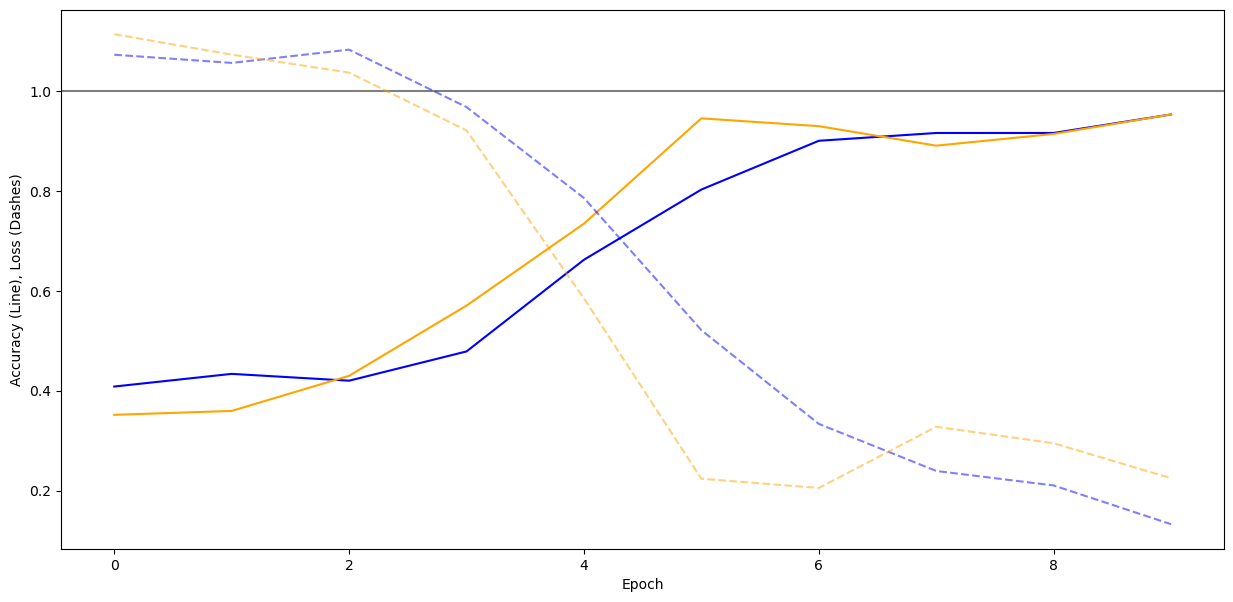

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 14ms/step
before [[3.33983362e-01 7.22747995e-04 6.65293872e-01]
 [9.98533964e-01 1.32018700e-03 1.45865721e-04]
 [9.99803126e-01 3.59010010e-05 1.61010845e-04]
 [1.43010519e-04 3.43093634e-05 9.99822676e-01]
 [9.99775350e-01 1.42501129e-04 8.21027570e-05]
 [9.99958515e-01 4.13266025e-05 1.10794119e-07]
 [9.99994636e-01 5.23363610e-07 4.92620757e-06]
 [8.93003106e-01 1.02259822e-01 4.73698508e-03]
 [9.99865294e-01 8.91429736e-05 4.55725240e-05]
 [9.98525798e-01 2.31798040e-04 1.24243111e-03]
 [2.16164137e-03 5.30885300e-05 9.97785211e-01]
 [3.47636960e-05 9.99955535e-01 9.70045858e-06]
 [7.73004472e-01 2.05464706e-01 2.15308331e-02]
 [7.49689201e-03 9.73861548e-04 9.91529226e-01]
 [9.99993801e-01 6.19114189e-06 4.13512993e-08]
 [3.14649642e-02 1.44688447e-03 9.67088163e-01]
 [1.74559918e-05 9.99981046e-01 1.57841907e-06]
 [3.84383649e-03 1.98477210e-05 9.96136248e-01]
 [6.33150619e-03 9.50421810e-01 4.32466827e-02]
 [1.29185873e-03 8.93410106e-

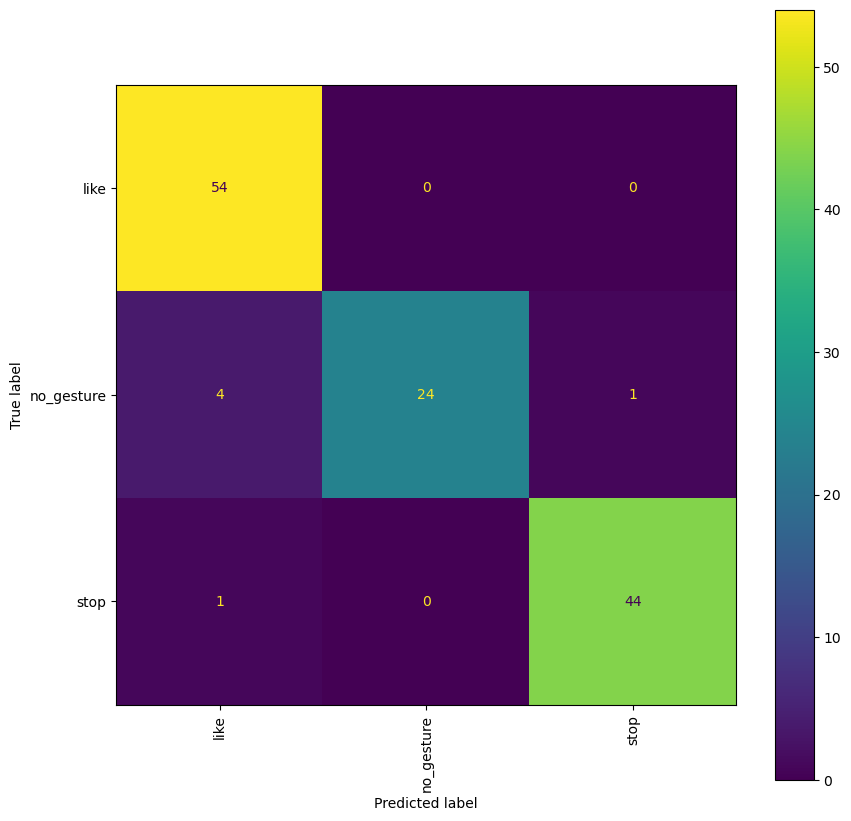

In [69]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [70]:
# 8 batch size

In [71]:
# variables for hyperparameters
batch_size = 32
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [72]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
16/16 [==============================] - 2s 87ms/step - loss: 1.0619 - accuracy: 0.3848 - val_loss: 1.0754 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 1s 82ms/step - loss: 1.0347 - accuracy: 0.4473 - val_loss: 1.0281 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 1s 81ms/step - loss: 1.0031 - accuracy: 0.4922 - val_loss: 0.9718 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 1s 78ms/step - loss: 0.9378 - accuracy: 0.5566 - val_loss: 0.8185 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 1s 79ms/step - loss: 0.7459 - accuracy: 0.6758 - val_loss: 0.6788 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 1s 78ms/step - loss: 0.6478 - accuracy: 0.7324 - val_loss: 0.4900 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 1s 78ms/step - loss: 0.5

In [73]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (32, 64, 64, 3)          0         
                                                                 
 random_contrast_13 (RandomC  (32, 64, 64, 3)          0         
 ontrast)                                                        
                                                                 
 conv2d_39 (Conv2D)          (32, 64, 64, 64)          15616     
                                                                 
 max_pooling2d_39 (MaxPoolin  (32, 16, 16, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (32, 16, 16, 32)          51232     
                                                                 
 max_pooling2d_40 (MaxPoolin  (32, 6, 6, 32)         

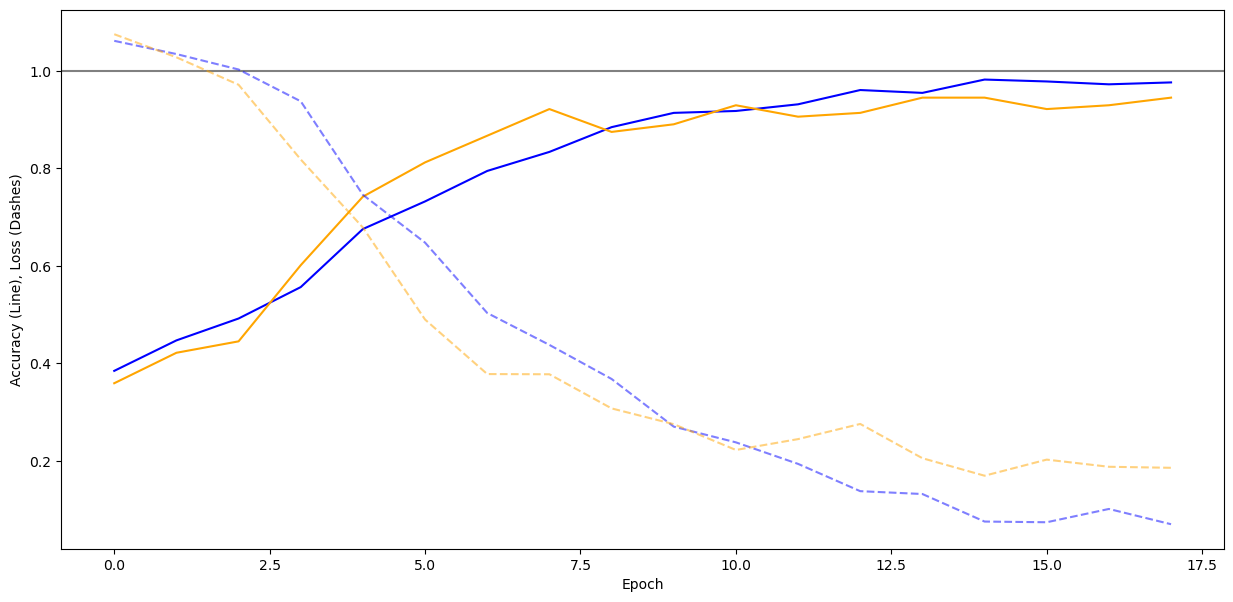

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 14ms/step
before [[1.44066006e-01 8.33640166e-04 8.55100334e-01]
 [9.98928964e-01 3.90592177e-04 6.80417230e-04]
 [9.93055761e-01 2.42392998e-04 6.70180004e-03]
 [3.41286039e-04 7.03097030e-05 9.99588430e-01]
 [9.99172866e-01 4.08674932e-05 7.86261866e-04]
 [9.99947667e-01 3.77626639e-05 1.45972308e-05]
 [9.99251187e-01 1.61757919e-06 7.47079903e-04]
 [1.22093474e-02 9.87645686e-01 1.44935053e-04]
 [9.99432623e-01 1.98762682e-05 5.47494506e-04]
 [9.98181462e-01 3.38611571e-05 1.78461545e-03]
 [3.80788650e-03 9.33869102e-04 9.95258272e-01]
 [2.23100251e-05 9.99616265e-01 3.61459301e-04]
 [5.33895910e-01 4.24924731e-01 4.11793441e-02]
 [3.13475914e-03 2.00033677e-03 9.94864881e-01]
 [9.99998689e-01 1.54304061e-07 1.14094018e-06]
 [6.60712365e-04 6.51538372e-04 9.98687804e-01]
 [4.03484264e-05 9.99958873e-01 8.24894698e-07]
 [2.22298404e-04 3.18188686e-05 9.99745905e-01]
 [1.96398981e-03 9.95691359e-01 2.34474777e-03]
 [1.77522757e-04 1.01015619e-

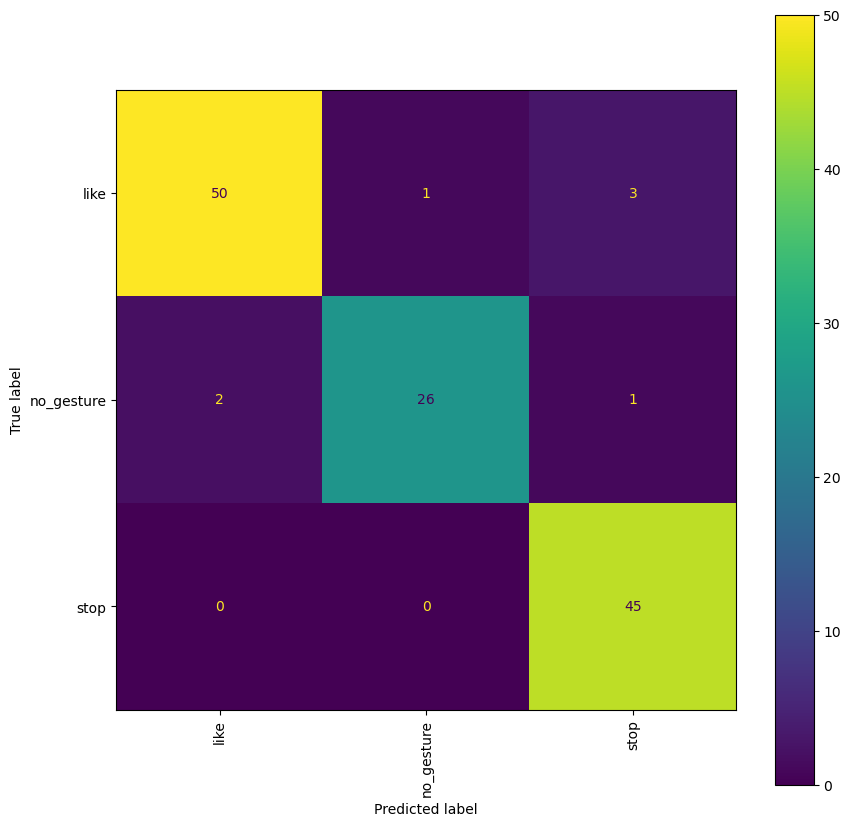

In [75]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [76]:
# 128 batch

In [77]:
# variables for hyperparameters
batch_size = 128
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [78]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
4/4 [==============================] - 2s 324ms/step - loss: 1.0611 - accuracy: 0.4160 - val_loss: 1.0422 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 1s 277ms/step - loss: 1.0064 - accuracy: 0.4746 - val_loss: 1.0062 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 1s 277ms/step - loss: 0.9903 - accuracy: 0.4824 - val_loss: 0.9555 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 1s 276ms/step - loss: 0.9413 - accuracy: 0.5234 - val_loss: 0.9055 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 1s 276ms/step - loss: 0.9171 - accuracy: 0.5645 - val_loss: 0.8883 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 1s 276ms/step - loss: 0.8493 - accuracy: 0.5957 - val_loss: 0.8773 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 1s 277ms/step - loss: 0.7904 - a

In [79]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip)  (128, 64, 64, 3)         0         
                                                                 
 random_contrast_14 (RandomC  (128, 64, 64, 3)         0         
 ontrast)                                                        
                                                                 
 conv2d_42 (Conv2D)          (128, 64, 64, 64)         15616     
                                                                 
 max_pooling2d_42 (MaxPoolin  (128, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (128, 16, 16, 32)         51232     
                                                                 
 max_pooling2d_43 (MaxPoolin  (128, 6, 6, 32)        

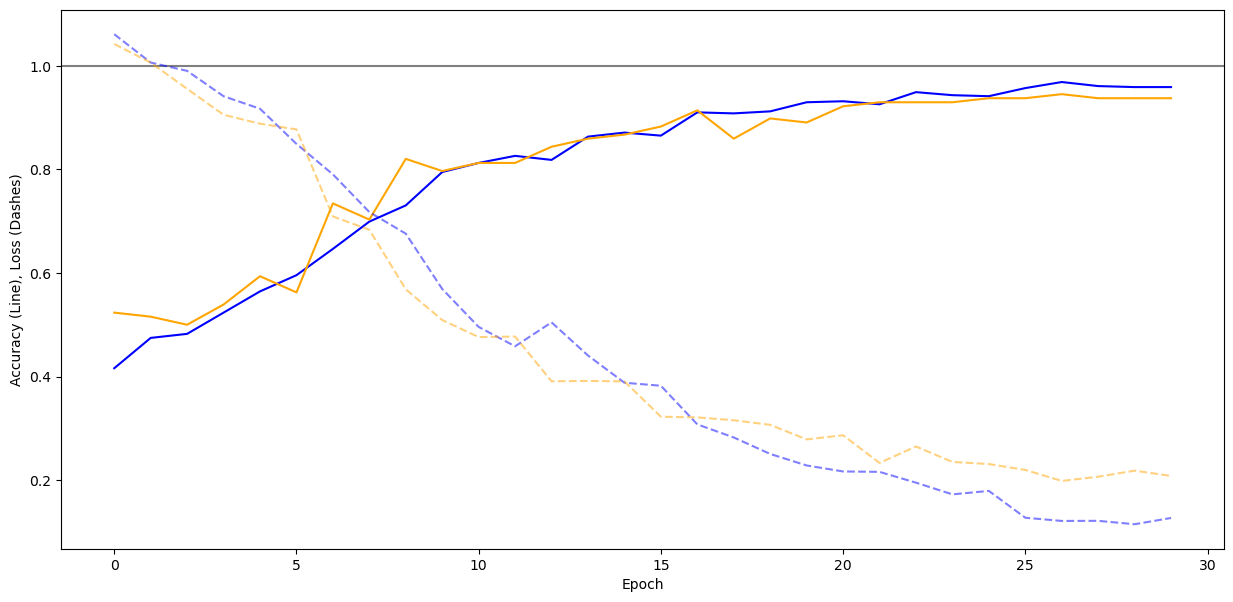

In [80]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 14ms/step
before [[1.19101964e-01 1.11516158e-03 8.79782856e-01]
 [9.99105155e-01 2.49012199e-04 6.45775173e-04]
 [9.30435061e-01 1.44538912e-03 6.81195855e-02]
 [3.25244881e-04 1.56004651e-04 9.99518752e-01]
 [9.99602258e-01 3.66483946e-05 3.61028768e-04]
 [9.99954700e-01 2.62674603e-05 1.90644205e-05]
 [9.97335374e-01 2.38019493e-05 2.64086411e-03]
 [2.23059744e-01 7.60533750e-01 1.64064635e-02]
 [9.99377728e-01 4.36377632e-05 5.78662148e-04]
 [9.98167992e-01 2.57908341e-05 1.80616579e-03]
 [4.26073745e-03 8.95257480e-03 9.86786723e-01]
 [6.93404931e-04 9.96897459e-01 2.40917061e-03]
 [8.55725706e-01 9.62769240e-02 4.79973182e-02]
 [3.01817595e-03 1.30800297e-03 9.95673835e-01]
 [9.99996543e-01 1.38492589e-06 2.00792101e-06]
 [5.11997100e-03 7.85741955e-02 9.16305900e-01]
 [3.19071405e-04 9.97881234e-01 1.79970544e-03]
 [7.36856193e-04 4.56675451e-04 9.98806477e-01]
 [6.95737731e-03 8.01703155e-01 1.91339523e-01]
 [2.04424351e-03 4.19272156e-

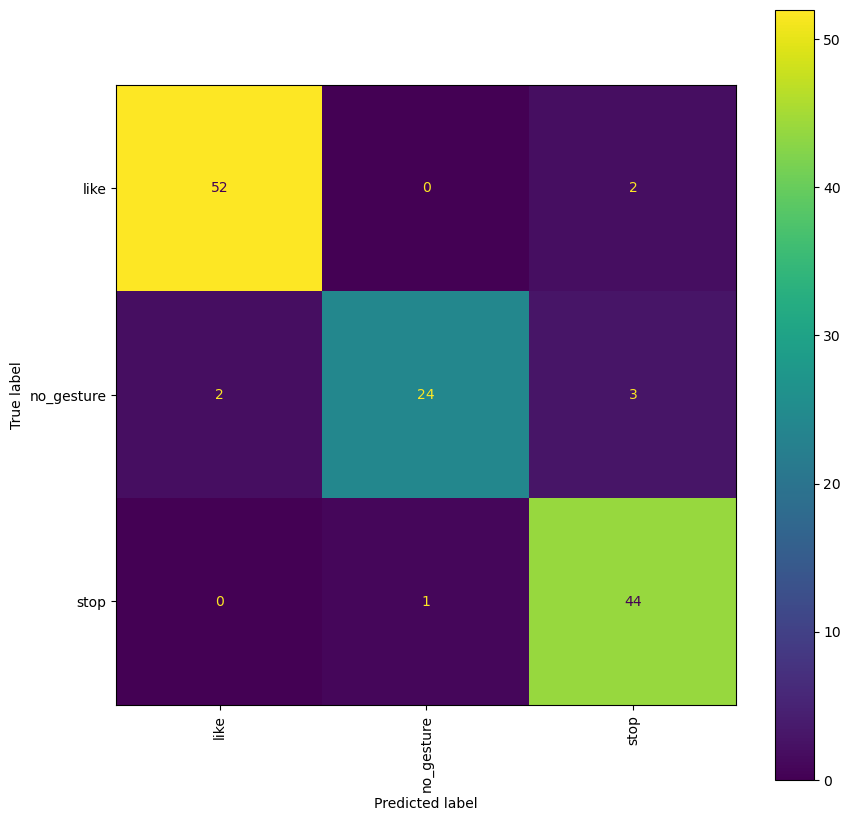

In [81]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [82]:
# 256 batch

In [83]:
# variables for hyperparameters
batch_size = 256
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [84]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
2/2 [==============================] - 2s 736ms/step - loss: 1.0877 - accuracy: 0.3984 - val_loss: 1.0569 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 1s 549ms/step - loss: 1.0488 - accuracy: 0.3828 - val_loss: 1.0552 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 1s 542ms/step - loss: 1.0426 - accuracy: 0.4219 - val_loss: 1.0488 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 1s 554ms/step - loss: 1.0274 - accuracy: 0.4375 - val_loss: 1.0381 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 1s 556ms/step - loss: 1.0182 - accuracy: 0.4805 - val_loss: 1.0049 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 1s 553ms/step - loss: 0.9867 - accuracy: 0.5215 - val_loss: 0.9655 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 7/50
2/2 [==============================] - 1s 548ms/step - loss: 0.9659 - a

In [85]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_15 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_15 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 6, 6, 32)       

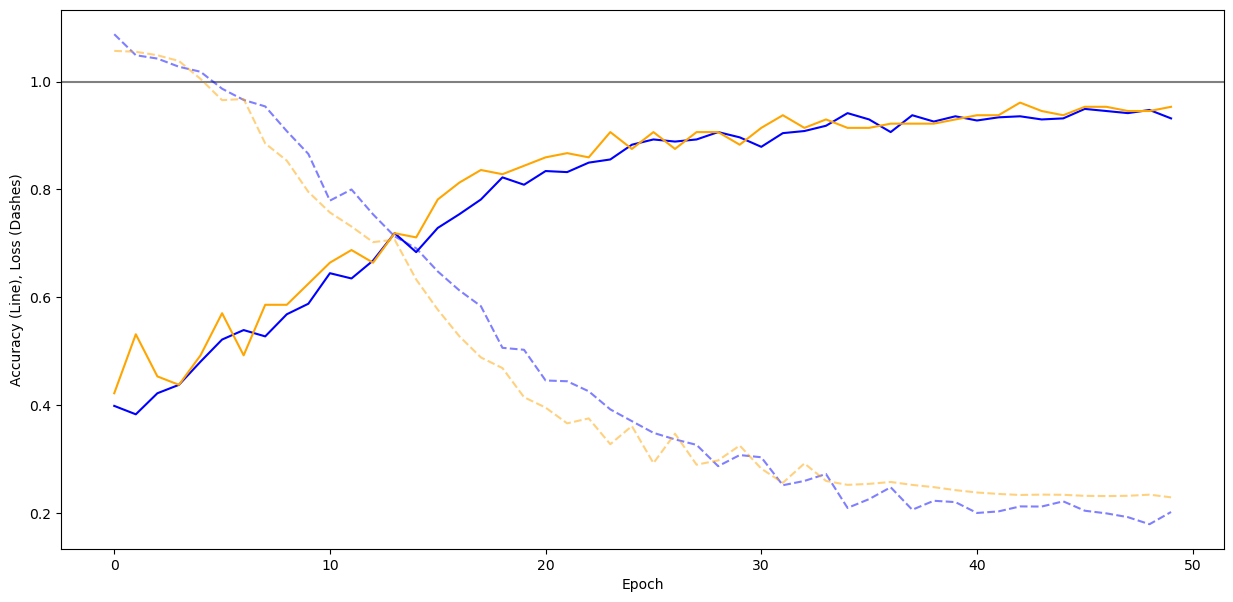

In [86]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 14ms/step
before [[1.98047653e-01 4.37230279e-04 8.01515162e-01]
 [9.93185282e-01 1.49713701e-03 5.31761767e-03]
 [8.99898171e-01 3.23141925e-03 9.68704447e-02]
 [1.69375027e-03 1.28401880e-04 9.98177886e-01]
 [9.92699087e-01 6.86765939e-04 6.61423896e-03]
 [9.99745548e-01 1.40762611e-04 1.13756076e-04]
 [9.68844771e-01 1.64135010e-04 3.09910439e-02]
 [3.67624879e-01 6.12535596e-01 1.98396184e-02]
 [9.91555035e-01 1.54832538e-04 8.29015765e-03]
 [9.86869395e-01 7.60073308e-05 1.30546577e-02]
 [1.02502480e-02 1.24082435e-02 9.77341473e-01]
 [6.33669412e-03 9.87563789e-01 6.09958218e-03]
 [7.60738850e-01 1.60676971e-01 7.85841867e-02]
 [3.26853991e-02 4.77943942e-03 9.62535083e-01]
 [9.99617934e-01 1.79751994e-04 2.02293231e-04]
 [2.21061576e-02 1.34234235e-01 8.43659639e-01]
 [3.40170646e-03 9.93391275e-01 3.20708076e-03]
 [6.00383012e-03 3.66968615e-03 9.90326464e-01]
 [3.75578292e-02 6.73461020e-01 2.88981199e-01]
 [1.04701845e-02 2.36018915e-

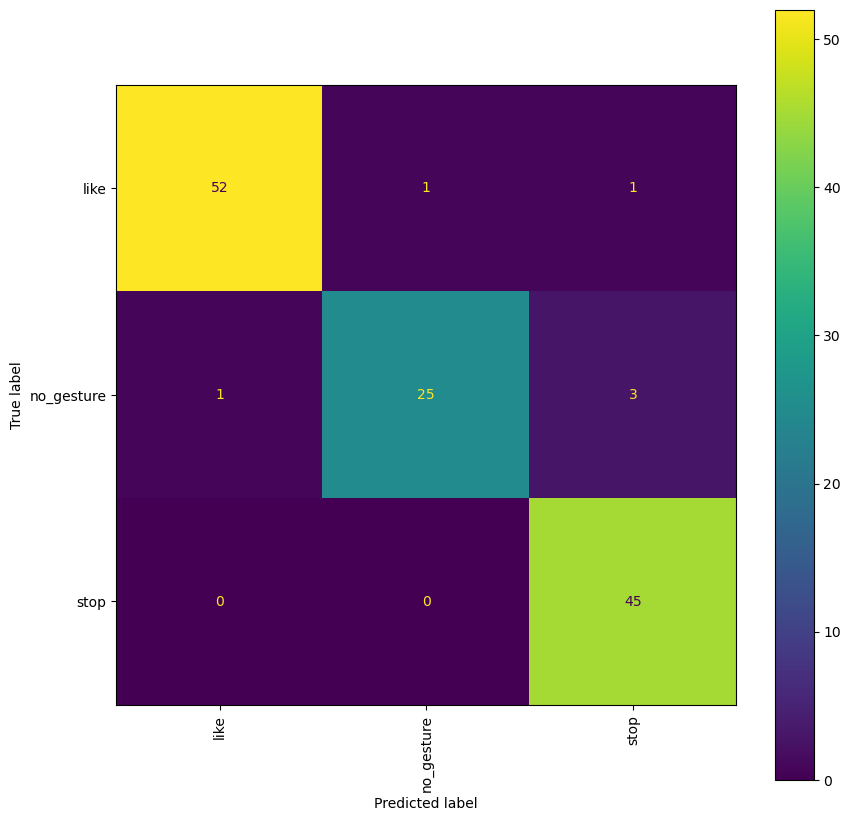

In [87]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [88]:
# 512 (max)

In [89]:
# variables for hyperparameters
batch_size = 512
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [90]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.1132 - accuracy: 0.2129 - val_loss: 1.0868 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1.0875 - accuracy: 0.3789 - val_loss: 1.0636 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 1.0598 - accuracy: 0.3828 - val_loss: 1.0792 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 1.0366 - accuracy: 0.4258 - val_loss: 1.0984 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 1.0524 - accuracy: 0.3965 - val_loss: 1.0901 - val_accuracy: 0.3516 - lr: 2.0000e-04


In [91]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_16 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_16 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 6, 6, 32)       

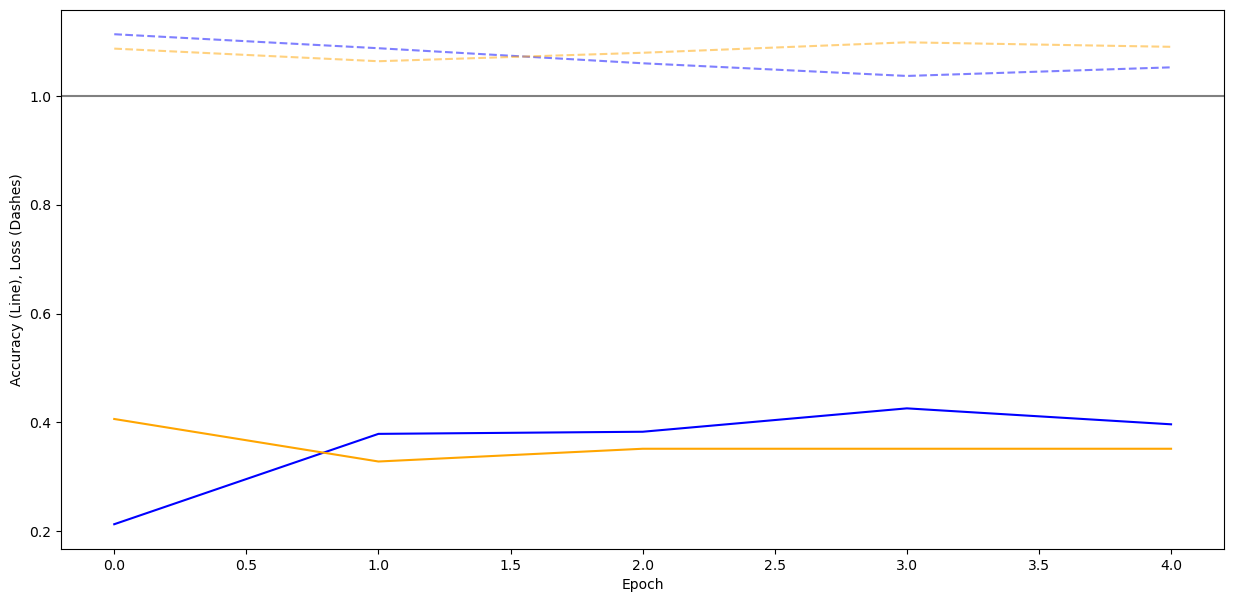

In [92]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 14ms/step
before [[0.36066803 0.10463911 0.53469276]
 [0.36863828 0.18911351 0.4422482 ]
 [0.34762707 0.12349658 0.52887636]
 [0.34143466 0.10839955 0.5501657 ]
 [0.37135673 0.15505768 0.47358558]
 [0.36467725 0.16828802 0.46703473]
 [0.39271832 0.12170673 0.485575  ]
 [0.39375183 0.12428088 0.4819673 ]
 [0.39422226 0.12859985 0.4771779 ]
 [0.36951753 0.12480246 0.50568   ]
 [0.37982082 0.13692665 0.48325256]
 [0.3775553  0.15095186 0.47149283]
 [0.34616604 0.25519755 0.3986364 ]
 [0.3592299  0.11560732 0.5251628 ]
 [0.3689276  0.1667529  0.4643195 ]
 [0.35052213 0.09879535 0.5506825 ]
 [0.3665006  0.1728112  0.4606882 ]
 [0.36636418 0.12398967 0.5096462 ]
 [0.358993   0.1950578  0.4459491 ]
 [0.37198758 0.12592952 0.5020828 ]
 [0.3569536  0.17390317 0.4691432 ]
 [0.34738958 0.11009055 0.54251987]
 [0.36770087 0.17214538 0.4601538 ]
 [0.35596332 0.13118216 0.5128545 ]
 [0.34660184 0.10666766 0.54673046]
 [0.34686616 0.12416229 0.5289715 ]
 [0.3

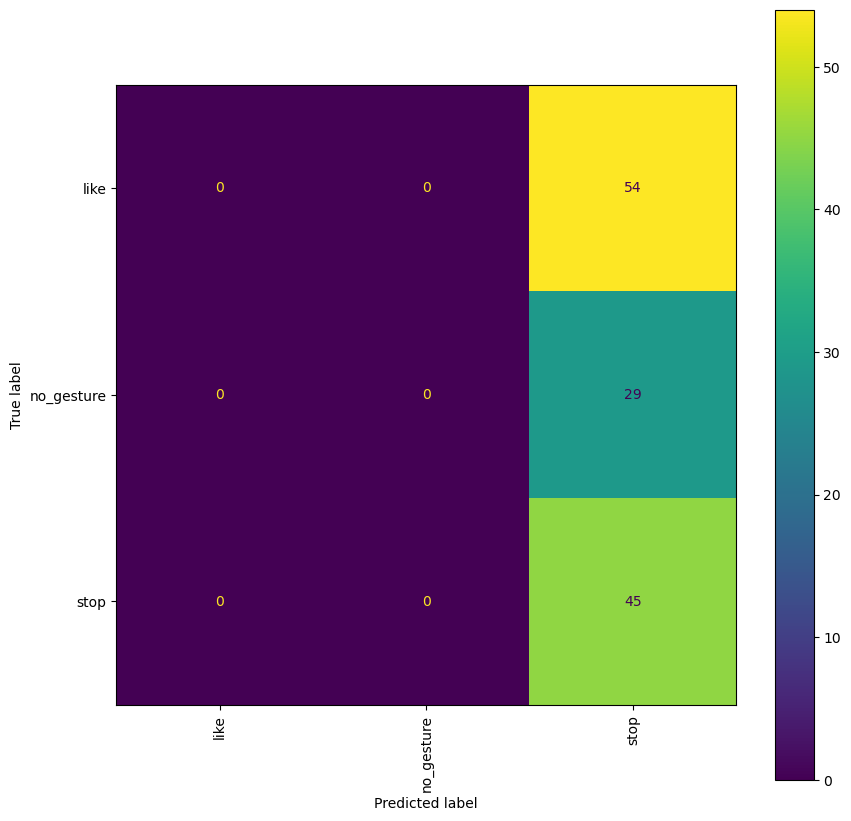

In [93]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# Results

| batch size | accuracy | val_accuracy | time per step | time per epoch | epochs needed |
|:----:|:----:|:----:|:----:|:----:|:----:|
| 1 | 0.9883 | 0.9688 | ~ 7 ms | ~ 4 s | 22 |
| 8 | 0.9531 | 0.9531 | ~ 24 ms | ~ 2 s | 10 |
| 32 | 0.9766 | 0.9453 | ~ 80 ms | ~ 1 s | 18 |
| 128 | 0.9590 | 0.9375 |  ~ 285 ms | ~ 1 s | 30 |
| 256 | 0.9316 | 0.9531 | ~ 600 ms | ~ 1 s | 50 |
| 512 | 0.3965 | 0.3516 |~ 1 s | ~ 1 s | 5 |

As you can see the worst accuracy is with bactch size 512 (0.3965 / val: 0.3416). Already after 5 epochs the accuracy couldn't get better, but with ~5 seconds training time it was the fastest. 

The best accuracy can be seen with batch size 1 (0.9883 / val: 0.9688), but it took around 88 seconds for the training.

As we can see: the higher the batch size, the lower the accuracy. Except for the batch size = 1, the time to train the model got longer with a higher batch size. But it seems that there is a point, where the model prediciton gets so bad, the model will cancel the training after few epochs, because no better results are shown (batch size 512).

The plots of accuracy and loss of the training process also shows this visually. 

The batch size = 1 was very quick for a rather good prediction, in the last ~8 epochs not much progress in better accuracy was made. The plot with the maximum batch size shows that after one epoch accuracy couldn't approve.

### Plots of accuracy and loss of the training process

#### batch size = 1 
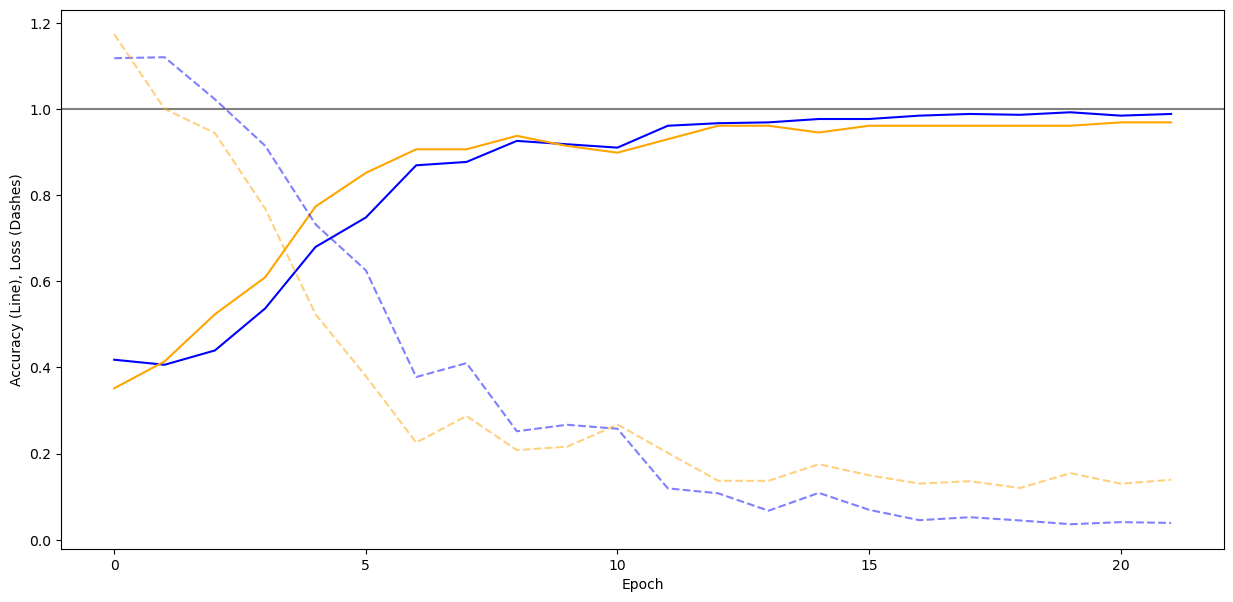

#### batch size = 8
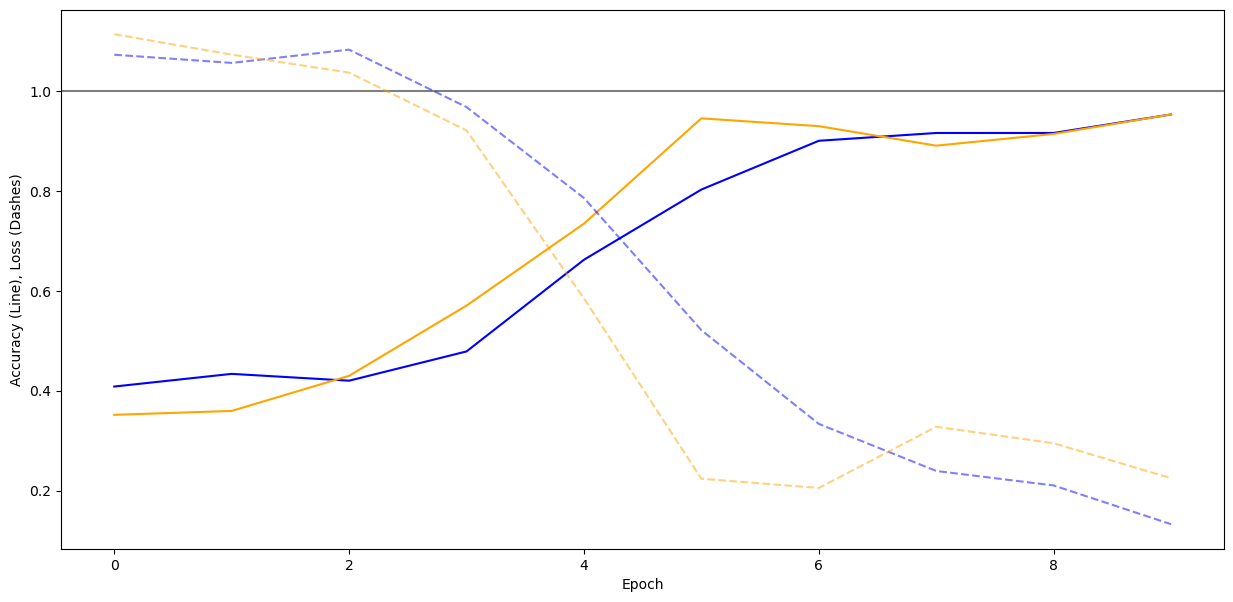

#### batch size = 32
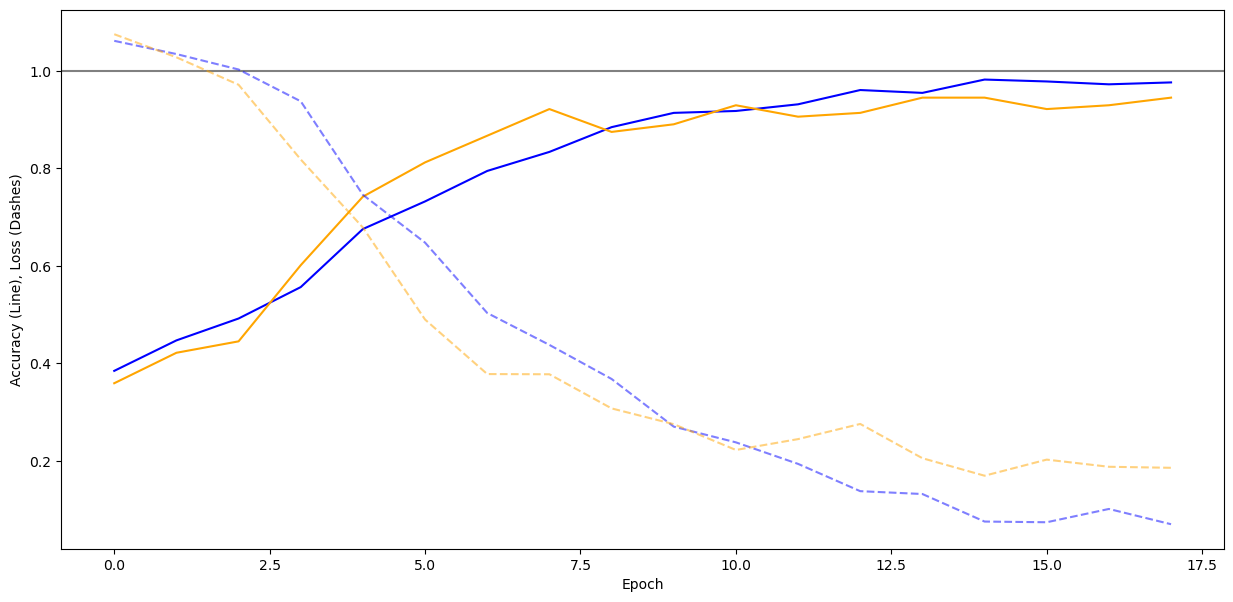

#### batch size = 128
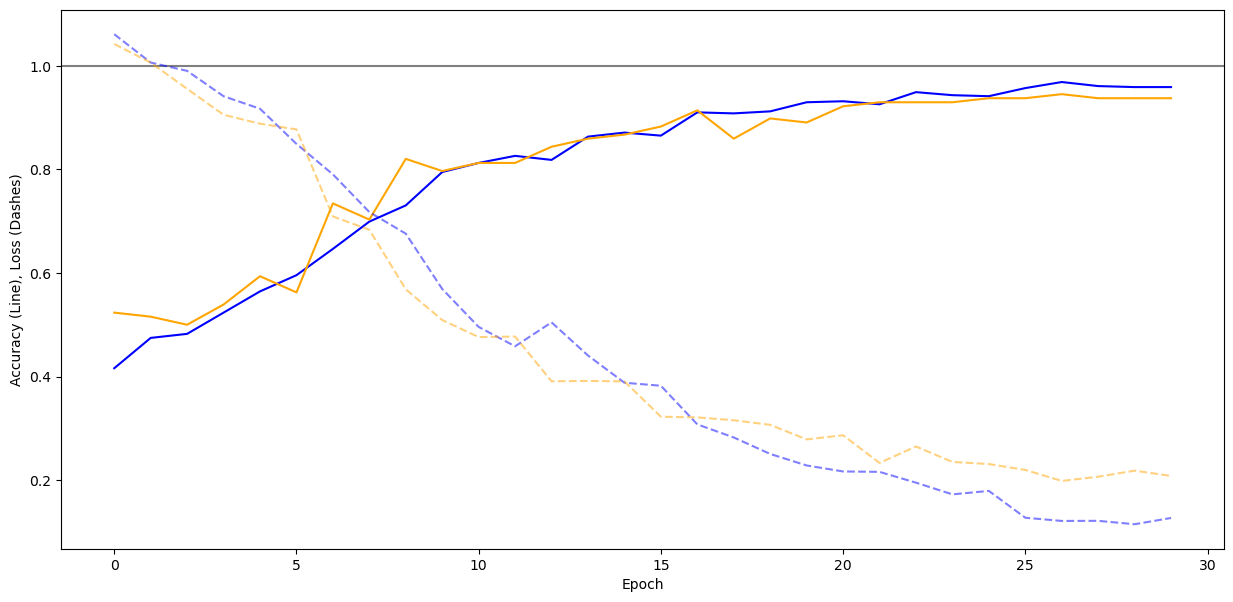

#### batch size = 256 
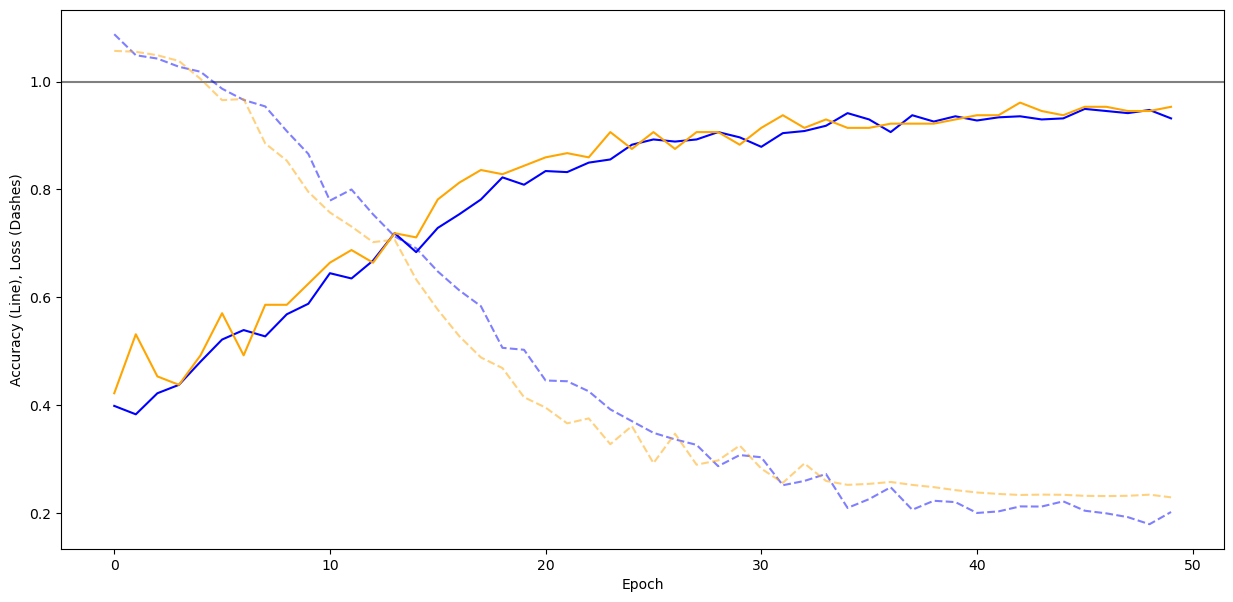

#### batch size = 512
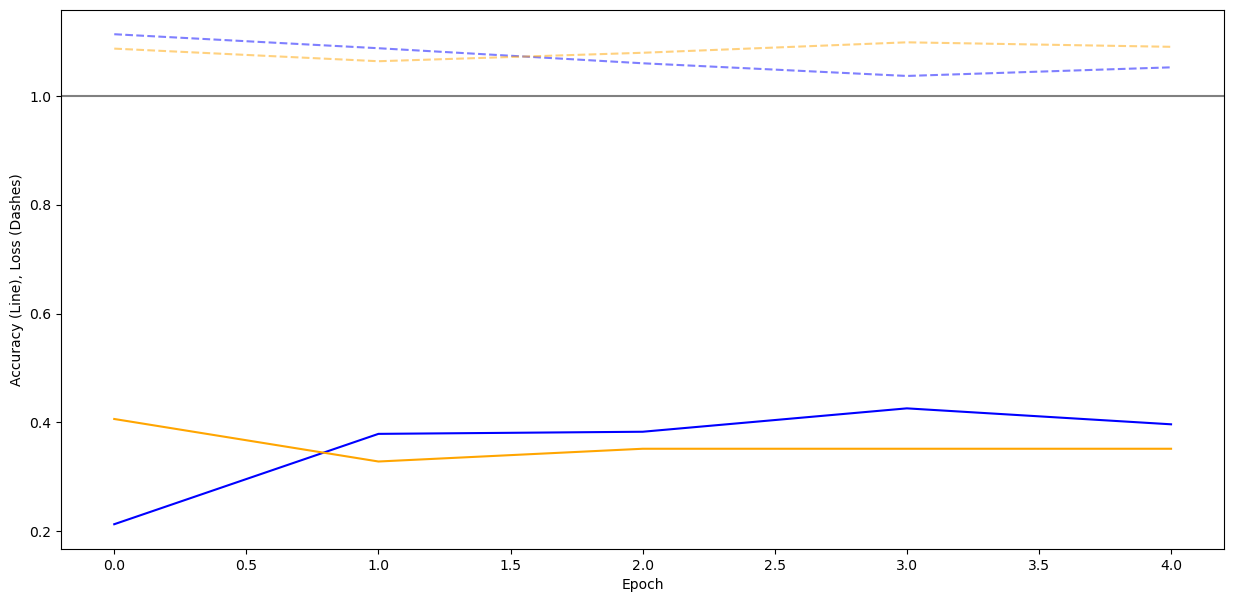